# Model Building

## Import Libraries and Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score

In [2]:
# Load your data
df = pd.read_csv("eta_data.csv")

## Define Columns

In [3]:
# Columns
col = ['distance_km', 'customer_state', 'seller_city', 'customer_city', 'seller_id', 'seller_state']
target_col = 'delivery_time_hours'

# Make categorical columns as category dtype
categorical_cols = ['customer_state', 'seller_city', 'customer_city', 'seller_id', 'seller_state']
for c in categorical_cols:
    df[c] = df[c].astype('category')

# Features and target
X = df[col]
y = df[target_col]

## Train-test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (4000, 6)
Test shape: (1000, 6)


## Define XGBoost model

In [5]:
base_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_weight=3,
    gamma=0.5,
    random_state=100,
    enable_categorical=True
)

In [6]:
base_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


## Make predictions

In [7]:
y_pred_train = base_model.predict(X_train)
y_pred_test = base_model.predict(X_test)

## Evaluate model

In [8]:
# Train metrics
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

# Test metrics
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")

Train RMSE: 2.0550, R2: 0.9883
Test RMSE: 2.7568, R2: 0.9804


# Model Validation & Robustness

## Cross Validation

### XGBoost CV to find optimal rounds

In [9]:
# Prepare DMatrix
dmatrix = xgb.DMatrix(X, label=y, enable_categorical=True)

# Parameters dict
params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.05,
    "max_depth": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "min_child_weight": 3,
    "gamma": 0.5,
    "seed": 100
}

# 5-fold CV with early stopping
cv_results = xgb.cv(
    params=params,
    dtrain=dmatrix,
    num_boost_round=300,
    nfold=5,
    metrics="rmse",
    early_stopping_rounds=50,
    seed=100,
    as_pandas=True,
    verbose_eval=False
)

print("Best number of boosting rounds:", len(cv_results))
print("Best CV RMSE:", cv_results['test-rmse-mean'].min())


Best number of boosting rounds: 300
Best CV RMSE: 2.6841477767264528


### Train full model on all data with optimal rounds

In [10]:
best_rounds = len(cv_results)

model = xgb.XGBRegressor(
    n_estimators=best_rounds,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_weight=3,
    gamma=0.5,
    random_state=100,
    enable_categorical=True
)

model.fit(X, y)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


### Compute R² using cross_val_predict

In [11]:
# 5-fold cross-validated predictions
y_pred_cv = cross_val_predict(model, X, y, cv=5, n_jobs=-1)

# R²
r2_cv = r2_score(y, y_pred_cv)
print("Cross-validated R²:", r2_cv)

Cross-validated R²: 0.9802696108818054


## Residual Analysis

### Get predictions

In [12]:
# If using full data
y_pred = model.predict(X)

# Residuals
residuals = y - y_pred

### Basic residual plot (residuals vs predicted)

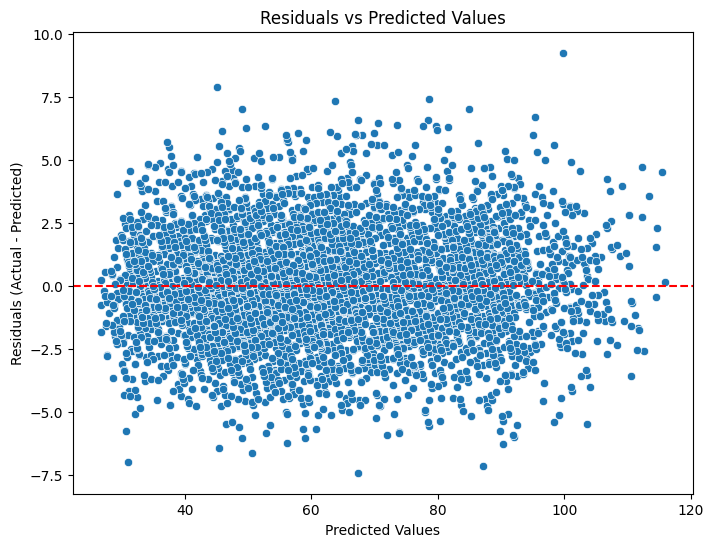

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Predicted Values")
plt.show()

### Histogram / distribution of residuals

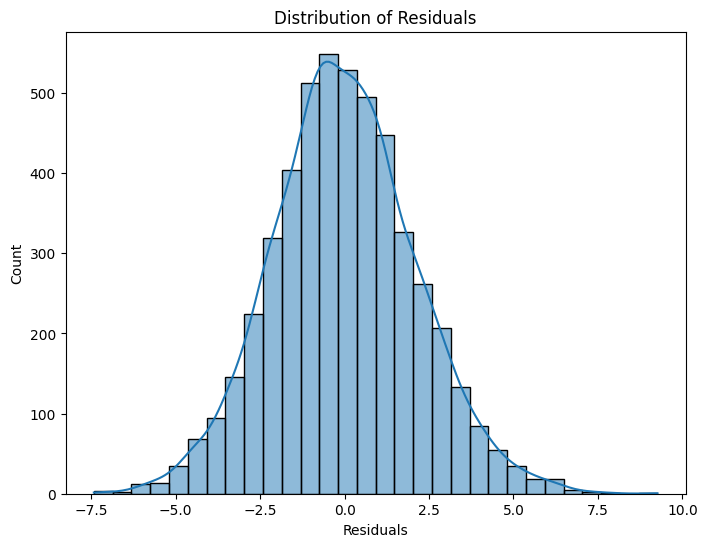

In [14]:
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
plt.show()

### Q-Q plot (Normality check)

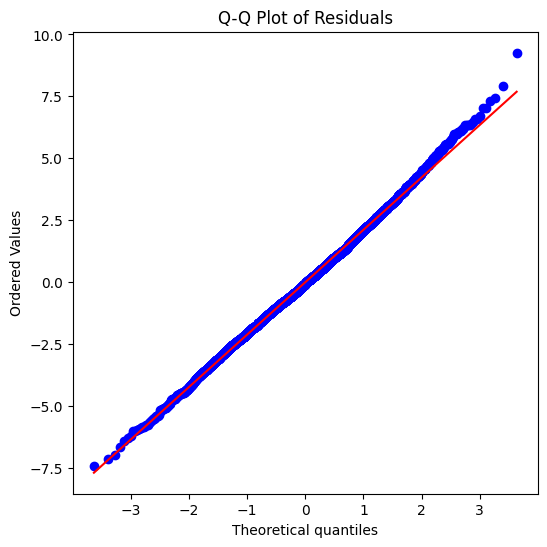

In [15]:
import scipy.stats as stats

plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

### Residuals vs each feature

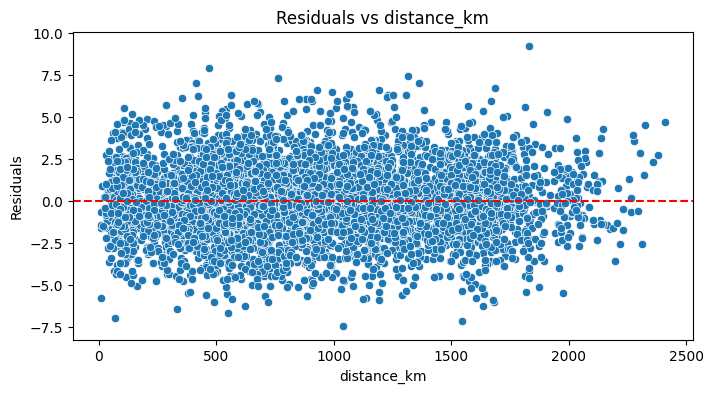

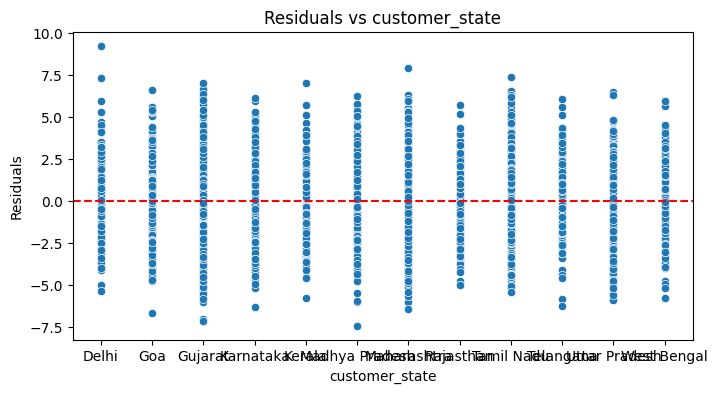

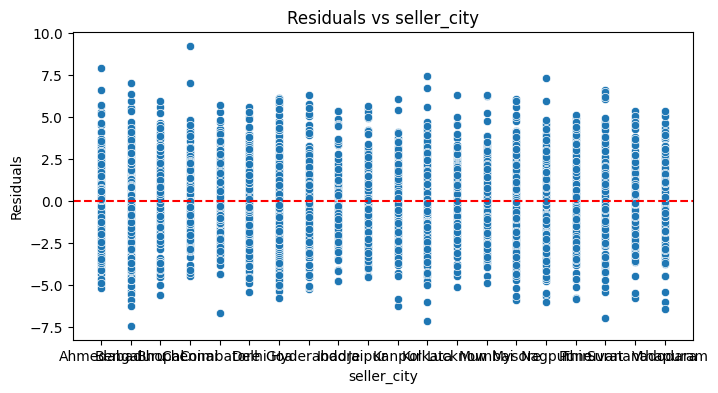

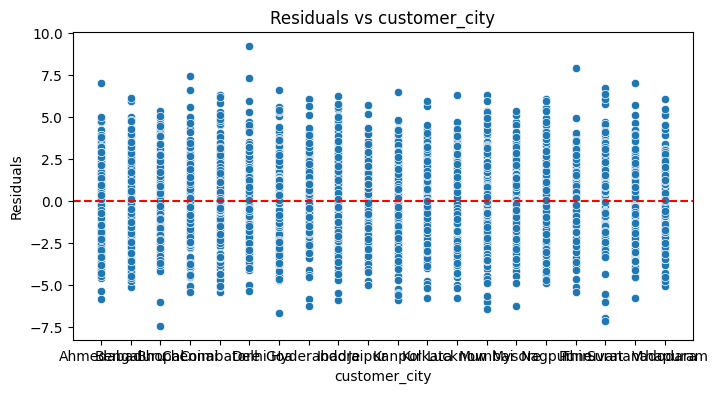

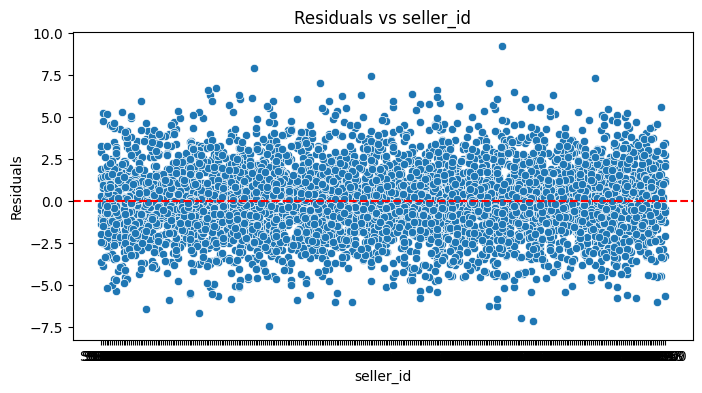

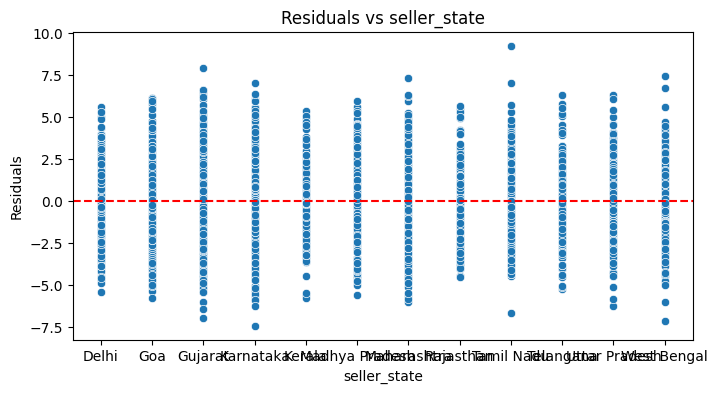

In [16]:
for feature in X.columns:
    plt.figure(figsize=(8,4))
    sns.scatterplot(x=X[feature], y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel(feature)
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs {feature}")
    plt.show()

## Stress Testing

### Identify key features for stress scenarios

In [17]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

print(importance_df)


          feature  importance
0     distance_km    0.745745
5    seller_state    0.088121
1  customer_state    0.059616
4       seller_id    0.054826
2     seller_city    0.026651
3   customer_city    0.025040


### Create “stress test” scenarios

In [18]:
# Example: extreme distance, unusual customer/seller combination
stress_data = pd.DataFrame({
    'distance_km': [0.1, 500, 1000],  # very short, very long
    'customer_state': ['CA', 'NY', 'TX'],  # common or edge states
    'seller_city': ['San Francisco', 'Albany', 'Houston'],
    'customer_city': ['Los Angeles', 'Buffalo', 'Dallas'],
    'seller_id': ['S001', 'S999', 'S123'],  # rare or typical sellers
    'seller_state': ['CA', 'NY', 'TX']
})

# Convert categorical columns
categorical_cols = ['customer_state', 'seller_city', 'customer_city', 'seller_id', 'seller_state']
for c in categorical_cols:
    stress_data[c] = stress_data[c].astype('category')


### Predict with stress test data

In [19]:
y_pred_stress = model.predict(stress_data)

stress_data['predicted_delivery_time'] = y_pred_stress
print(stress_data)

   distance_km customer_state    seller_city customer_city seller_id  \
0          0.1             CA  San Francisco   Los Angeles      S001   
1        500.0             NY         Albany       Buffalo      S999   
2       1000.0             TX        Houston        Dallas      S123   

  seller_state  predicted_delivery_time  
0           CA                34.414410  
1           NY                44.914505  
2           TX                63.555801  


### Analyze stress test results

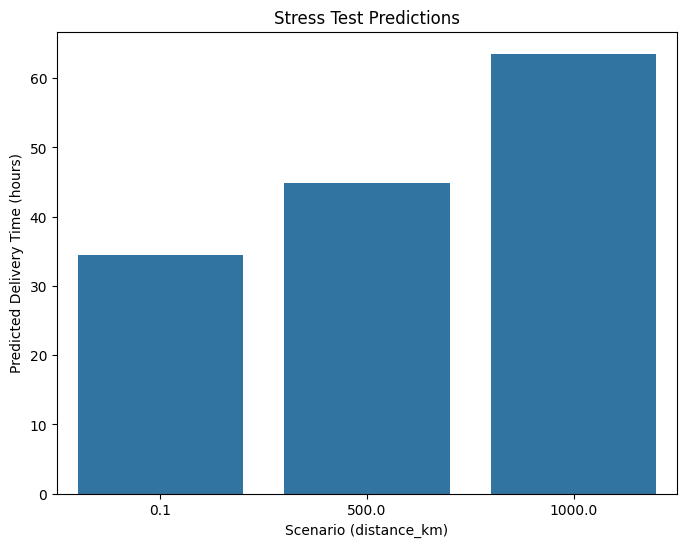

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.barplot(x=stress_data.index, y=stress_data['predicted_delivery_time'])
plt.xticks(ticks=range(len(stress_data)), labels=stress_data['distance_km'])
plt.xlabel("Scenario (distance_km)")
plt.ylabel("Predicted Delivery Time (hours)")
plt.title("Stress Test Predictions")
plt.show()

# Save the model 

In [21]:
import joblib

joblib.dump(model, "xgb_model.pkl")

['xgb_model.pkl']